In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__)
    print(module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib
3.1.2
numpy
1.17.4
pandas
0.25.3
sklearn
0.22
tensorflow
2.0.0
tensorflow_core.keras
2.2.4-tf


## 1. 准备并处理数据

In [2]:
# 获取数据集
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [3]:
# 划分数据集
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target,)
#                                                             random_state= 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, )
#                                                       random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

## 2. 建立模型

### 2.1 【重点】使用子类建立自定义层

In [5]:
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(CustomizedDenseLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.layers.Activation(activation)
        
    def build(self, input_shape):
        """构建所需要的参数，在使用keras.models.Model重载模型的时候，
        重载的是__init__()，它是将__init__()方法和buid()方法合在一起
        了，而重载层时时分开写的"""
        self.kernel = self.add_weight(name="kernel",
                                      shape=(input_shape[1], self.units),
                                      initializer="uniform",
                                      trainable=True)
        self.bias = self.add_weight(name="bias",
                                    shape=self.units,
                                    initializer="zeros",
                                    trainable=True)
        super(CustomizedDenseLayer, self).build(input_shape) # 这句好像有无都无所谓
    
    def call(self, x):
        """正向计算"""
        return self.activation(x @ self.kernel + self.bias)

### 2.2 【重点】使用keras.layers.Layer类，把无参数的简单函数变为一个layer

In [6]:
# customized activation function
def py_softplus(x):
    return tf.math.log(tf.exp(x) + 1)

In [7]:
# 建立激活函数层
# 等同于customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x)) 
customized_softplus = keras.layers.Lambda(lambda x: py_softplus(x))
print(customized_softplus)

In [8]:
# 自定义模型几种方法（回顾）
# 方法一：使用序列模型进行建模
model = keras.models.Sequential([
    CustomizedDenseLayer(30, 
                         activation="relu",
                         input_shape=x_train.shape[1:]
                        ),
    CustomizedDenseLayer(1),
    customized_softplus
    # 上面这个customized_softplus层还以用一下两种方式实现
    # 方式(a)
    # keras.layers.Dense(1, activation="softplus")
    # 方式(b)
    # keras.layers.Dense(1)
    # keras.layers.Activation("softplus")
])

# 方法二：使用函数式API进行建模
# input = keras.layers.Input(shape=x_train.shape[1:])
# hidden1 = CustomizedDenseLayer(30, activation="relu")(input)
# hidden2 = CustomizedDenseLayer(1)(hidden1)
# output = customized_softplus(hidden2)
# model = keras.models.Model(input, output)

# 方法三：使用子类API进行建模
# class CustomizedModel(keras.models.Model):
#     def __init__(self):
#         super(CustomizedModel, self).__init__()
#         self.hidden1_layer = CustomizedDenseLayer(30, activation="relu")
#         self.hidden2_layer = CustomizedDenseLayer(1)
#         self.output_layer = customized_softplus
    
#     def call(self, inputs):
#         hidden1 = self.hidden1_layer(inputs)
#         hidden2 = self.hidden2_layer(hidden1)
#         outputs = self.output_layer(hidden2)
#         return outputs

# model = CustomizedModel()
# model.build(input_shape=(None, 8))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer (Cust (None, 30)                270       
_________________________________________________________________
customized_dense_layer_1 (Cu (None, 1)                 31        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss="mse", optimizer="sgd")

## 3. 模型训练

In [11]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = model.fit(x_train_scaled,
                    y_train,
                    epochs=100,
                    validation_data=[x_valid_scaled, y_valid],
                    callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 96us/sample - loss: 1.2014 - val_loss: 0.6709
Epoch 2/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.6104 - val_loss: 0.5849
Epoch 3/100
11610/11610 [==============================] - 1s 48us/sample - loss: 0.5454 - val_loss: 0.5319
Epoch 4/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5093 - val_loss: 0.5020
Epoch 5/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4917 - val_loss: 0.4868
Epoch 6/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4814 - val_loss: 0.4835
Epoch 7/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.4728 - val_loss: 0.4705
Epoch 8/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4657 - val_loss: 0.4599
Epoch 9/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.458

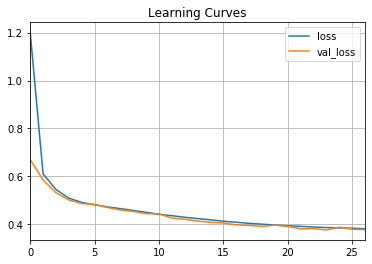

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(6,4), grid=True)
    plt.title("Learning Curves")
    plt.show()
plot_learning_curves(history)

## 4. 模型预测

In [13]:
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.37939112334288366